In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import math
import os
import datetime as dt
import seaborn as sns

%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score, explained_variance_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Embedding, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM
#from tensorflow.keras.layers import Flatten, GRU, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, LambdaCallback
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers

## Functions

In [2]:
def train_test_split_func(df):
    train_start = 0
    train_end = int(np.floor(0.80*len(df)))
    test_start = train_end
    test_end = len(df)
    train = df[train_start:train_end]
    test = df[test_start:test_end]
    return train, test

In [3]:
# Data normalization
scaler = MinMaxScaler()

In [4]:
# Write a function to split data into X and Y
def window(data, his_num):
    inputs = []
    output = []
    k = len(data) - his_num - 1
    for i in range(k): 
        inputs.append(data[i: i + his_num,1:])
        output.append(data[i + his_num, 0])
        X = np.array(inputs)
        Y = np.array(output)

    return X, Y

In [5]:
def baseModel(X_train):
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=5, padding='same', activation='relu'))
    
    model.add(LSTM(16, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='relu')) #Use relu because close prices are all positive numbers.
  
    es_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=.0005,patience=2,verbose=0,mode='auto',baseline=None,restore_best_weights=True)

    return model

In [6]:
def ModelOne(X_train):
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=5, padding='same', activation='relu'))
    
    model.add(LSTM(32, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='relu')) #Use relu because close prices are all positive numbers.
  
    es_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=.0005,patience=2,verbose=0,mode='auto',baseline=None,restore_best_weights=True)

    return model

In [7]:
def compare_plot(predict, actual):
    plt.figure(figsize = (15, 6))
    plt.plot(predict,"b",label="predicted")
    plt.plot(actual,"r",label="actual")
    plt.legend()
    plt.show()

# Gasoline

## Oil futures only

In [8]:
#root = r'C:\Users\DELL\Desktop\IAQF 2021\data'
# dataset = pd.read_csv(root + '/gas_spot_futures.csv')#,index_col = 'Date', parse_dates = True)
df = pd.read_csv('/Users/katez/Desktop/IAQFCompetitionWinners2020/data_gasoline.csv')

#df = pd.read_csv(root + '/data_gasoline.csv')
df.set_index(["Date"], inplace=True)
df['oil_futures'] =  df['oil_futures'].diff().shift(2)
df

,gasoline,oil_futures,close1,close2,close3,close4,close5,spring,summer,fall,winter,gas_1,gas_2
Date,,,,,,,,,,,,,
9/11/00,1.598,NaN,33.700001,35.330002,34.950001,33.799999,33.380001,0,0,1,0,NaN,NaN
9/18/00,1.599,NaN,35.849998,34.099998,33.799999,34.200001,35.099998,0,0,1,0,1.598,NaN
9/25/00,1.586,NaN,32.650002,33.950001,37.500000,36.500000,36.880001,0,0,1,0,1.599,1.598
10/2/00,1.563,1.780003,30.860001,30.299999,31.500000,31.500000,31.570000,0,0,1,0,1.586,1.599
10/9/00,1.541,-5.310001,30.850000,30.650000,31.500000,32.070000,32.150002,0,0,1,0,1.563,1.586
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/21/20,2.311,0.419998,49.099998,48.360001,47.820000,47.619999,46.990002,0,0,0,1,2.247,2.246
12/28/20,2.330,1.230004,48.119999,47.020000,47.740002,49.099998,48.360001,0,0,0,1,2.311,2.247
1/4/21,2.336,0.750000,48.520000,48.400002,48.000000,47.619999,48.119999,0,0,0,1,2.330,2.311


In [9]:
data = df[['gasoline','oil_futures','close1','close2','close3','close4','close5']]
data = data.dropna()
data

,gasoline,oil_futures,close1,close2,close3,close4,close5
Date,,,,,,,
10/2/00,1.563,1.780003,30.860001,30.299999,31.500000,31.500000,31.570000
10/9/00,1.541,-5.310001,30.850000,30.650000,31.500000,32.070000,32.150002
10/16/00,1.578,0.580002,35.049999,36.099998,33.150002,33.150002,31.879999
10/23/00,1.588,-0.270003,34.299999,32.950001,33.549999,32.950001,33.099998
10/30/00,1.584,1.219999,32.700001,33.750000,32.959999,33.369999,33.730000
...,...,...,...,...,...,...,...
12/21/20,2.311,0.419998,49.099998,48.360001,47.820000,47.619999,46.990002
12/28/20,2.330,1.230004,48.119999,47.020000,47.740002,49.099998,48.360001
1/4/21,2.336,0.750000,48.520000,48.400002,48.000000,47.619999,48.119999


In [10]:
train, test = train_test_split_func(data)
train=scaler.fit_transform(train)
test=scaler.transform(test)

In [11]:
X_train, y_train = window(train, 1)
X_test, y_test = window(test, 1)

In [12]:
print("X train shape:",X_train.shape, " test shape:",X_test.shape)
print("y train shape:",y_train.shape, " test shape:",y_test.shape)

X train shape: (794, 1, 6)  test shape: (198, 1, 6)
y train shape: (794,)  test shape: (198,)


In [13]:
# Train the base model
model0 = ModelOne(X_train)
model0.compile(optimizer="adam", loss="mean_squared_error")  

model0.fit(X_train, y_train, epochs=15, batch_size = 10, shuffle=True)
model0.evaluate(X_test,y_test)

# PREDICTION
y_train_base = model0.predict(X_train)
y_test_base = model0.predict(X_test)

Train on 794 samples
Epoch 1/15
794/794 [==============================] - 7s 9ms/sample - loss: 0.1330
Epoch 2/15
794/794 [==============================] - 1s 902us/sample - loss: 0.0141
Epoch 3/15
794/794 [==============================] - 1s 916us/sample - loss: 0.0089
Epoch 4/15
794/794 [==============================] - 1s 904us/sample - loss: 0.0086
Epoch 5/15
794/794 [==============================] - 1s 900us/sample - loss: 0.0084
Epoch 6/15
794/794 [==============================] - 1s 941us/sample - loss: 0.0082
Epoch 7/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0077
Epoch 8/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0083
Epoch 9/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0078
Epoch 10/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0074
Epoch 11/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0069
Epoch 12/15
794/794 [==============================] -

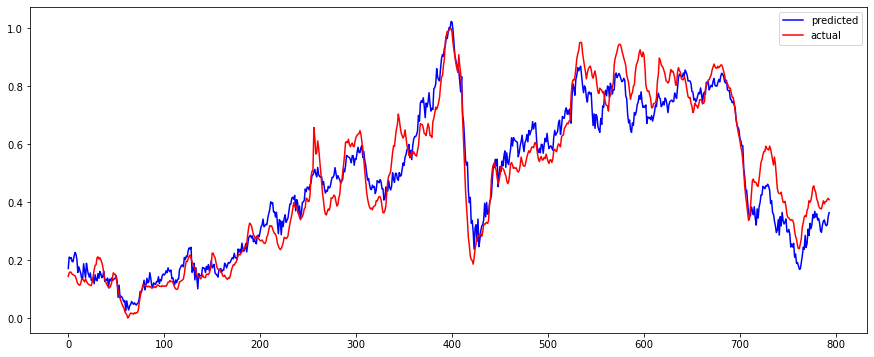

In [14]:
compare_plot(y_train_base,y_train)

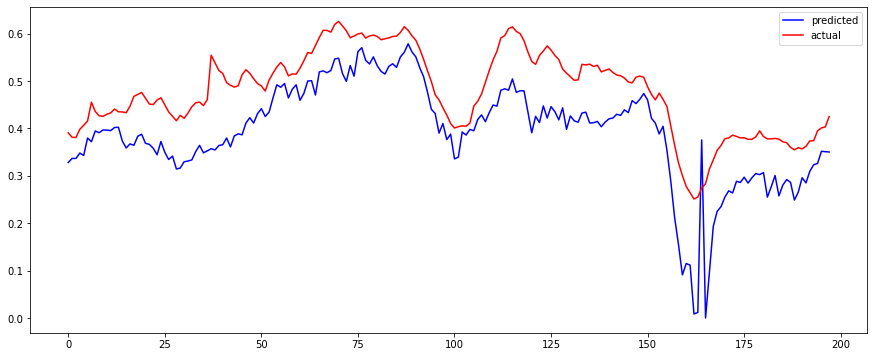

In [15]:
compare_plot(y_test_base,y_test) 

In [16]:
#Calculate RMSE of train and test
mse_train = mean_squared_error(y_train, y_train_base)
print("Train Data MSE = ", mse_train)
rmse_train = mean_squared_error(y_train, y_train_base,squared=False)
print("Train Data RMSE = ", rmse_train)
print("")
mse_test = mean_squared_error(y_test, y_test_base)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_test, y_test_base,squared=False)
print("Test Data RMSE = ", rmse_test)

Train Data MSE =  0.0049167841108261725
Train Data RMSE =  0.07011978401867887

Test Data MSE =  0.009316066917679425
Test Data RMSE =  0.09651977474942337


## Add seasonality

In [17]:
data = df.drop(['gas_1','gas_2'],axis=1)
data = data.dropna()
data

,gasoline,oil_futures,close1,close2,close3,close4,close5,spring,summer,fall,winter
Date,,,,,,,,,,,
10/2/00,1.563,1.780003,30.860001,30.299999,31.500000,31.500000,31.570000,0,0,1,0
10/9/00,1.541,-5.310001,30.850000,30.650000,31.500000,32.070000,32.150002,0,0,1,0
10/16/00,1.578,0.580002,35.049999,36.099998,33.150002,33.150002,31.879999,0,0,1,0
10/23/00,1.588,-0.270003,34.299999,32.950001,33.549999,32.950001,33.099998,0,0,1,0
10/30/00,1.584,1.219999,32.700001,33.750000,32.959999,33.369999,33.730000,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
12/21/20,2.311,0.419998,49.099998,48.360001,47.820000,47.619999,46.990002,0,0,0,1
12/28/20,2.330,1.230004,48.119999,47.020000,47.740002,49.099998,48.360001,0,0,0,1
1/4/21,2.336,0.750000,48.520000,48.400002,48.000000,47.619999,48.119999,0,0,0,1


In [18]:
train, test = train_test_split_func(data)
train=scaler.fit_transform(train)
test=scaler.transform(test)
X_train, y_train = window(train, 1)
X_test, y_test = window(test, 1)

In [19]:
print("X train shape:",X_train.shape, " test shape:",X_test.shape)
print("y train shape:",y_train.shape, " test shape:",y_test.shape)

X train shape: (794, 1, 10)  test shape: (198, 1, 10)
y train shape: (794,)  test shape: (198,)


In [20]:
# Train the base model
model0 = ModelOne(X_train)
model0.compile(optimizer="adam", loss="mean_squared_error")  

model0.fit(X_train, y_train, epochs=15, batch_size = 10, shuffle=True)
model0.evaluate(X_test, y_test)

# PREDICTION
y_train_base = model0.predict(X_train)
y_test_base = model0.predict(X_test)

Train on 794 samples
Epoch 1/15
794/794 [==============================] - 7s 9ms/sample - loss: 0.1156
Epoch 2/15
794/794 [==============================] - 1s 924us/sample - loss: 0.0127
Epoch 3/15
794/794 [==============================] - 1s 912us/sample - loss: 0.0090
Epoch 4/15
794/794 [==============================] - 1s 936us/sample - loss: 0.0090
Epoch 5/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0077
Epoch 6/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0074
Epoch 7/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0068
Epoch 8/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0065
Epoch 9/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0066
Epoch 10/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0062
Epoch 11/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0064
Epoch 12/15
794/794 [==============================] - 1s 

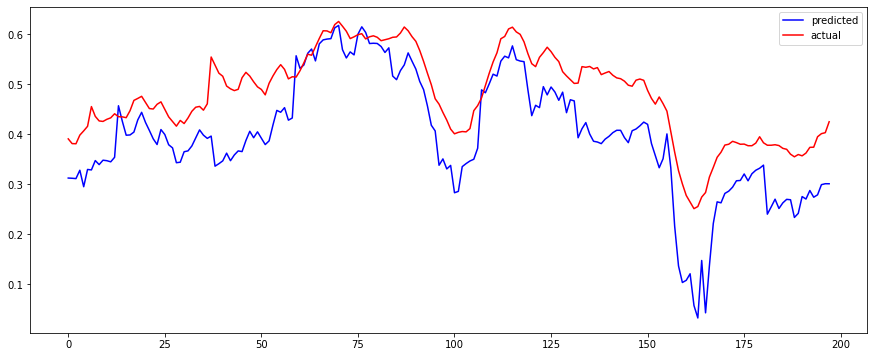

In [21]:
compare_plot(y_test_base,y_test) 

In [22]:
#Calculate RMSE of train and test
mse_train = mean_squared_error(y_train, y_train_base)
print("Train Data MSE = ", mse_train)
rmse_train = mean_squared_error(y_train, y_train_base,squared=False)
print("Train Data RMSE = ", rmse_train)
print("")
mse_test = mean_squared_error(y_test, y_test_base)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_test, y_test_base,squared=False)
print("Test Data RMSE = ", rmse_test)

Train Data MSE =  0.004270806268921439
Train Data RMSE =  0.0653514060209988

Test Data MSE =  0.008694515160484273
Test Data RMSE =  0.09324438406941339


## Add last week gasoline

In [23]:
data = df.drop(['gas_2'],axis=1)
data = data.dropna()
data

,gasoline,oil_futures,close1,close2,close3,close4,close5,spring,summer,fall,winter,gas_1
Date,,,,,,,,,,,,
10/2/00,1.563,1.780003,30.860001,30.299999,31.500000,31.500000,31.570000,0,0,1,0,1.586
10/9/00,1.541,-5.310001,30.850000,30.650000,31.500000,32.070000,32.150002,0,0,1,0,1.563
10/16/00,1.578,0.580002,35.049999,36.099998,33.150002,33.150002,31.879999,0,0,1,0,1.541
10/23/00,1.588,-0.270003,34.299999,32.950001,33.549999,32.950001,33.099998,0,0,1,0,1.578
10/30/00,1.584,1.219999,32.700001,33.750000,32.959999,33.369999,33.730000,0,0,1,0,1.588
...,...,...,...,...,...,...,...,...,...,...,...,...
12/21/20,2.311,0.419998,49.099998,48.360001,47.820000,47.619999,46.990002,0,0,0,1,2.247
12/28/20,2.330,1.230004,48.119999,47.020000,47.740002,49.099998,48.360001,0,0,0,1,2.311
1/4/21,2.336,0.750000,48.520000,48.400002,48.000000,47.619999,48.119999,0,0,0,1,2.330


In [24]:
train, test = train_test_split_func(data)
train=scaler.fit_transform(train)
test=scaler.transform(test)
X_train, y_train = window(train, 1)
X_test, y_test = window(test, 1)

In [25]:
print("X train shape:",X_train.shape, " test shape:",X_test.shape)
print("y train shape:",y_train.shape, " test shape:",y_test.shape)

X train shape: (794, 1, 11)  test shape: (198, 1, 11)
y train shape: (794,)  test shape: (198,)


In [26]:
# Train the base model
model0 = ModelOne(X_train)
model0.compile(optimizer="adam", loss="mean_squared_error")  

model0.fit(X_train, y_train, epochs=15, batch_size = 10, shuffle=True)
model0.evaluate(X_test, y_test)

# PREDICTION
y_train_base = model0.predict(X_train)
y_test_base = model0.predict(X_test)

Train on 794 samples
Epoch 1/15
794/794 [==============================] - 7s 9ms/sample - loss: 0.1000
Epoch 2/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0113
Epoch 3/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0078
Epoch 4/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0074
Epoch 5/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0070
Epoch 6/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0067
Epoch 7/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0051
Epoch 8/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0055
Epoch 9/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0051
Epoch 10/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0040
Epoch 11/15
794/794 [==============================] - 1s 1ms/sample - loss: 0.0039
Epoch 12/15
794/794 [==============================] - 1s 1ms/sa

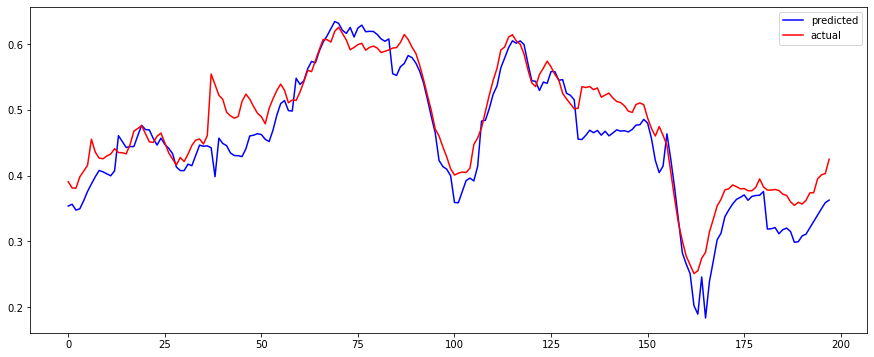

In [27]:
compare_plot(y_test_base,y_test) 

In [28]:
#Calculate RMSE of train and test
mse_train = mean_squared_error(y_train, y_train_base)
print("Train Data MSE = ", mse_train)
rmse_train = mean_squared_error(y_train, y_train_base,squared=False)
print("Train Data RMSE = ", rmse_train)
print("")
mse_test = mean_squared_error(y_test, y_test_base)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_test, y_test_base,squared=False)
print("Test Data RMSE = ", rmse_test)

Train Data MSE =  0.0014894324664108327
Train Data RMSE =  0.03859316605839475

Test Data MSE =  0.0014657400107406678
Test Data RMSE =  0.03828498414183644


## Add Other Additional

In [29]:
add = pd.read_csv('/Users/katez/Desktop/IAQFCompetitionWinners2020/Features.csv')  

In [30]:
add.set_index(["Date"], inplace=True)
add_data = pd.merge(data,add,how='left',on='Date')
add_data = add_data.dropna()

In [31]:
add_data

,gasoline,oil_futures,close1,close2,close3,close4,close5,spring,summer,fall,winter,gas_1,Heating Oil Price,Gold Price,USD_Index,Refinary Operation Capacity
Date,,,,,,,,,,,,,,,,
10/2/00,1.563,1.780003,30.860001,30.299999,31.500000,31.500000,31.570000,0,0,1,0,1.586,0.9330,269.299988,114.849998,94.7
10/9/00,1.541,-5.310001,30.850000,30.650000,31.500000,32.070000,32.150002,0,0,1,0,1.563,1.0170,272.399994,115.860001,92.4
10/16/00,1.578,0.580002,35.049999,36.099998,33.150002,33.150002,31.879999,0,0,1,0,1.541,0.9711,271.200012,117.160004,90.9
10/23/00,1.588,-0.270003,34.299999,32.950001,33.549999,32.950001,33.099998,0,0,1,0,1.578,0.9777,264.399994,117.389999,92.4
10/30/00,1.584,1.219999,32.700001,33.750000,32.959999,33.369999,33.730000,0,0,1,0,1.588,0.9217,264.600006,114.970001,93.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/30/20,2.211,1.049999,45.709999,44.910000,43.060001,42.150002,41.740002,0,0,1,0,2.194,1.4030,1835.900024,90.699997,78.2
12/7/20,2.246,1.720001,46.259998,45.639999,45.279999,44.549999,45.340000,0,0,0,1,2.211,1.4369,1839.800049,90.980003,79.9
12/14/20,2.247,2.279999,46.570000,46.779999,45.520000,45.599998,45.759998,0,0,0,1,2.246,1.5130,1885.699951,90.019997,79.1


In [32]:
train, test = train_test_split_func(add_data)
train=scaler.fit_transform(train)
test=scaler.transform(test)
X_train, y_train = window(train, 1)
X_test, y_test = window(test, 1)

In [33]:
print("X train shape:",X_train.shape, " test shape:",X_test.shape)
print("y train shape:",y_train.shape, " test shape:",y_test.shape)

X train shape: (792, 1, 15)  test shape: (197, 1, 15)
y train shape: (792,)  test shape: (197,)


In [34]:
# Train the base model
model0 = ModelOne(X_train)
model0.compile(optimizer="adam", loss="mean_squared_error")  

model0.fit(X_train, y_train, epochs=15, batch_size = 10, shuffle=True)
model0.evaluate(X_test, y_test)

# PREDICTION
y_train_base = model0.predict(X_train)
y_test_base = model0.predict(X_test)

Train on 792 samples
Epoch 1/15
792/792 [==============================] - 7s 9ms/sample - loss: 0.1131
Epoch 2/15
792/792 [==============================] - 1s 994us/sample - loss: 0.0089
Epoch 3/15
792/792 [==============================] - 1s 1ms/sample - loss: 0.0073
Epoch 4/15
792/792 [==============================] - 1s 1ms/sample - loss: 0.0061
Epoch 5/15
792/792 [==============================] - 1s 1ms/sample - loss: 0.0052
Epoch 6/15
792/792 [==============================] - 1s 1ms/sample - loss: 0.0052
Epoch 7/15
792/792 [==============================] - 1s 1ms/sample - loss: 0.0044
Epoch 8/15
792/792 [==============================] - 1s 1ms/sample - loss: 0.0044
Epoch 9/15
792/792 [==============================] - 1s 1ms/sample - loss: 0.0045
Epoch 10/15
792/792 [==============================] - 1s 1ms/sample - loss: 0.0039
Epoch 11/15
792/792 [==============================] - 1s 1ms/sample - loss: 0.0034
Epoch 12/15
792/792 [==============================] - 1s 1ms/

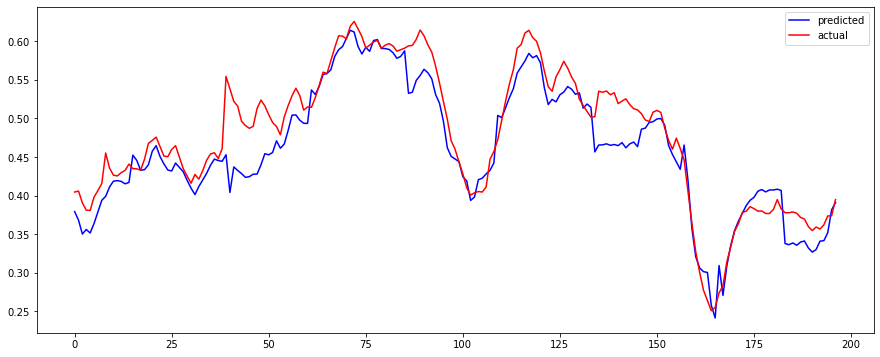

In [35]:
compare_plot(y_test_base,y_test) 

In [36]:
#Calculate RMSE of train and test
mse_train = mean_squared_error(y_train, y_train_base)
print("Train Data MSE = ", mse_train)
rmse_train = mean_squared_error(y_train, y_train_base,squared=False)
print("Train Data RMSE = ", rmse_train)
print("")
mse_test = mean_squared_error(y_test, y_test_base)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_test, y_test_base,squared=False)
print("Test Data RMSE = ", rmse_test)

Train Data MSE =  0.0015517686751752857
Train Data RMSE =  0.039392495163105445

Test Data MSE =  0.0010771742141671742
Test Data RMSE =  0.03282033232871316


# CO2

## oil futures only

In [69]:
co2 = pd.read_csv('/Users/katez/Desktop/IAQFCompetitionWinners2020/data_CO2.csv')
#co2 = pd.read_csv(root + '/data_CO2.csv',index_col = 'Date', parse_dates = True)

In [70]:
co2.set_index(["Date"], inplace=True)
#co2 = co2.drop(['',''],axis=1)
co2_oil = co2[['co2_ppm','oil_futures']]
co2_oil['oil_futures'] = co2_oil['oil_futures'].diff()
co2_oil = co2_oil.dropna()
co2_oil

/Users/katez/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,co2_ppm,oil_futures
Date,,
9/11/00,367.33,2.229999
9/18/00,366.86,1.780003
9/25/00,366.86,-5.310001
10/2/00,366.78,0.580002
10/9/00,366.88,-0.270003
...,...,...
1/18/21,415.42,0.045001
1/25/21,416.01,-0.215000
1/25/21,416.01,8.930441


In [71]:
co2_train, co2_test = train_test_split_func(co2_oil)

In [72]:
co2_train=scaler.fit_transform(co2_train)
co2_test=scaler.transform(co2_test)

In [73]:
X_co2_train, y_co2_train = window(co2_train, 3)
X_co2_test, y_co2_test = window(co2_test, 3)

In [74]:
print("X train shape:",X_co2_train.shape, " test shape:",X_co2_test.shape)
print("y train shape:",y_co2_train.shape, " test shape:",y_co2_test.shape)

X train shape: (849, 3, 1)  test shape: (210, 3, 1)
y train shape: (849,)  test shape: (210,)


In [75]:
# Train the base model
model0 = ModelOne(X_co2_train)
model0.compile(optimizer="adam", loss="mean_squared_error")  

model0.fit(X_co2_train, y_co2_train, epochs=15, batch_size = 10, shuffle=True)
model0.evaluate(X_co2_test, y_co2_test)

# PREDICTION
y_train_co2 = model0.predict(X_co2_train)
y_test_co2 = model0.predict(X_co2_test)

Train on 849 samples
Epoch 1/15
849/849 [==============================] - 7s 8ms/sample - loss: 0.0857
Epoch 2/15
849/849 [==============================] - 1s 1ms/sample - loss: 0.0595
Epoch 3/15
849/849 [==============================] - 1s 1ms/sample - loss: 0.0601
Epoch 4/15
849/849 [==============================] - 1s 1ms/sample - loss: 0.0626
Epoch 5/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0613
Epoch 6/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0615
Epoch 7/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0610
Epoch 8/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0610
Epoch 9/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0604
Epoch 10/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0608
Epoch 11/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0595
Epoch 12/15
849/849 [==============================] - 1s 2ms/sa

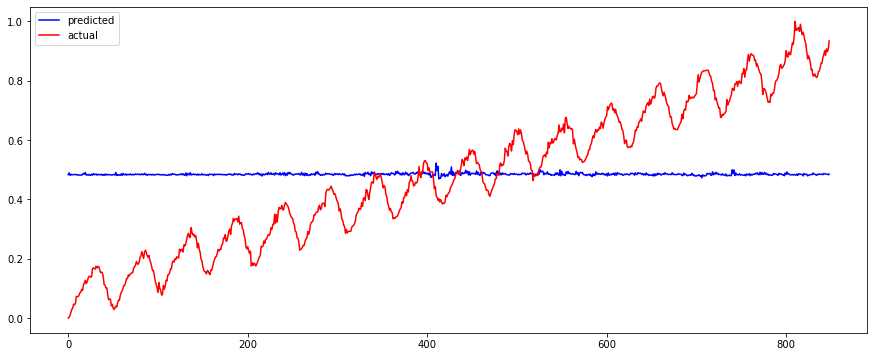

In [76]:
compare_plot(y_train_co2,y_co2_train) 

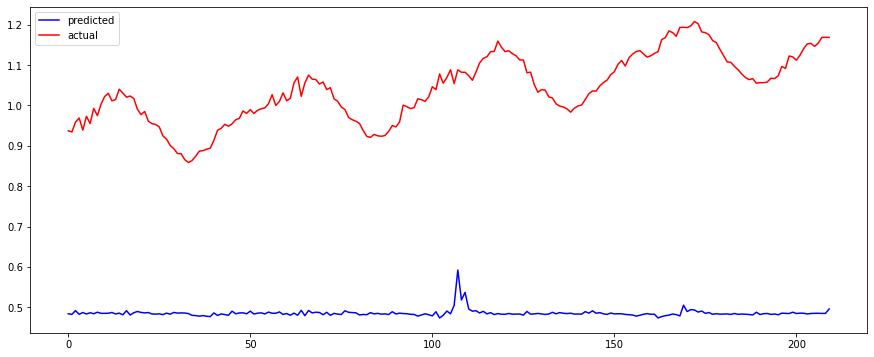

In [77]:
compare_plot(y_test_co2,y_co2_test) 

In [78]:
#Calculate RMSE of train and test
mse_train = mean_squared_error(y_co2_train, y_train_co2)
print("Train Data MSE = ", mse_train)
rmse_train = mean_squared_error(y_co2_train, y_train_co2,squared=False)
print("Train Data RMSE = ", rmse_train)
print("")
mse_test = mean_squared_error(y_co2_test, y_test_co2)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_co2_test, y_test_co2,squared=False)
print("Test Data RMSE = ", rmse_test)

Train Data MSE =  0.05860023502294436
Train Data RMSE =  0.24207485417313457

Test Data MSE =  0.314104046358312
Test Data RMSE =  0.560449860699699


## Add seasonality

In [79]:
co2

,co2_ppm,oil_futures,crude_oil,NG_F,NG_S,spring,summer,fall,winter
Date,,,,,,,,,
9/4/00,367.32,32.869999,33.08,4.880,4.66,0,0,1,0
9/11/00,367.33,35.099998,34.42,5.205,4.82,0,0,1,0
9/18/00,366.86,36.880001,34.70,5.131,5.05,0,0,1,0
9/25/00,366.86,31.570000,35.49,5.200,5.17,0,0,1,0
10/2/00,366.78,32.150002,31.13,5.000,5.21,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1/18/21,415.42,52.905001,52.75,2.446,2.54,0,0,0,1
1/25/21,416.01,52.690001,52.82,2.564,2.71,0,0,0,1
1/25/21,416.01,61.620441,52.52,2.564,3.12,0,0,0,1


In [80]:
co2_season = co2[['co2_ppm','oil_futures','spring','summer','fall','winter']]
co2_season['oil_futures'] = co2_season['oil_futures'].diff()
co2_season = co2_season.dropna()
co2_season

/Users/katez/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,co2_ppm,oil_futures,spring,summer,fall,winter
Date,,,,,,
9/11/00,367.33,2.229999,0,0,1,0
9/18/00,366.86,1.780003,0,0,1,0
9/25/00,366.86,-5.310001,0,0,1,0
10/2/00,366.78,0.580002,0,0,1,0
10/9/00,366.88,-0.270003,0,0,1,0
...,...,...,...,...,...,...
1/18/21,415.42,0.045001,0,0,0,1
1/25/21,416.01,-0.215000,0,0,0,1
1/25/21,416.01,8.930441,0,0,0,1


In [81]:
co2_season_train, co2_season_test = train_test_split_func(co2_season)
co2_season_train=scaler.fit_transform(co2_season_train)
co2_season_test=scaler.transform(co2_season_test)
X_season_train, y_season_train = window(co2_season_train, 3)
X_season_test, y_season_test = window(co2_season_test, 3)
print("X train shape:",X_season_train.shape, " test shape:",X_season_test.shape)
print("y train shape:",y_season_train.shape, " test shape:",y_season_test.shape)

X train shape: (849, 3, 5)  test shape: (210, 3, 5)
y train shape: (849,)  test shape: (210,)


In [82]:
# Train the base model
model0 = ModelOne(X_season_train)
model0.compile(optimizer="adam", loss="mean_squared_error")  

model0.fit(X_season_train, y_season_train, epochs=15, batch_size = 10, shuffle=True)
model0.evaluate(X_season_test, y_season_test)

# PREDICTION
y_train_season = model0.predict(X_season_train)
y_test_season = model0.predict(X_season_test)

Train on 849 samples
Epoch 1/15
849/849 [==============================] - 6s 7ms/sample - loss: 0.0872
Epoch 2/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0591
Epoch 3/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0620
Epoch 4/15
849/849 [==============================] - 2s 2ms/sample - loss: 0.0586
Epoch 5/15
849/849 [==============================] - 2s 2ms/sample - loss: 0.0590
Epoch 6/15
849/849 [==============================] - 2s 2ms/sample - loss: 0.0596
Epoch 7/15
849/849 [==============================] - 2s 2ms/sample - loss: 0.0594
Epoch 8/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0596
Epoch 9/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0591
Epoch 10/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0579
Epoch 11/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0583
Epoch 12/15
849/849 [==============================] - 1s 2ms/sa

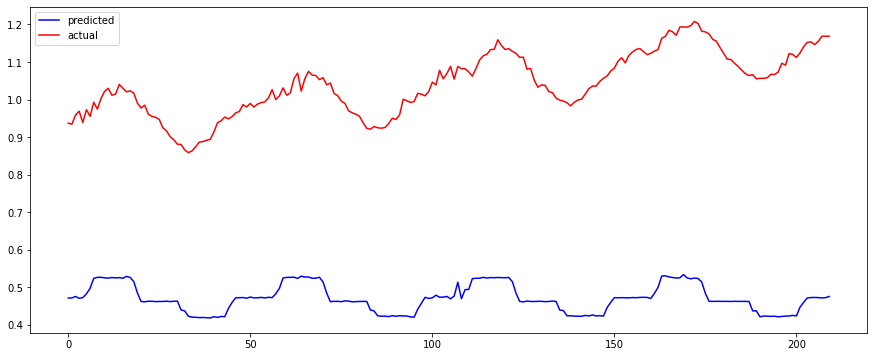

In [83]:
compare_plot(y_test_season,y_season_test) 

In [84]:
#Calculate RMSE of train and test
mse_train = mean_squared_error(y_season_train, y_train_season)
print("Train Data MSE = ", mse_train)
rmse_train = mean_squared_error(y_season_train, y_train_season,squared=False)
print("Train Data RMSE = ", rmse_train)
print("")
mse_test = mean_squared_error(y_season_test, y_test_season)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_season_test, y_test_season,squared=False)
print("Test Data RMSE = ", rmse_test)

Train Data MSE =  0.056792256664561
Train Data RMSE =  0.2383112600456827

Test Data MSE =  0.3293601792448398
Test Data RMSE =  0.5738991019724982


## Add Natural gas information

In [85]:
co2_ng = co2[['co2_ppm','oil_futures','NG_F']]
co2_ng['oil_futures'] = co2_ng['oil_futures'].diff()
co2_ng = co2_ng.dropna()
co2_ng

/Users/katez/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,co2_ppm,oil_futures,NG_F
Date,,,
9/11/00,367.33,2.229999,5.205
9/18/00,366.86,1.780003,5.131
9/25/00,366.86,-5.310001,5.200
10/2/00,366.78,0.580002,5.000
10/9/00,366.88,-0.270003,5.535
...,...,...,...
1/18/21,415.42,0.045001,2.446
1/25/21,416.01,-0.215000,2.564
1/25/21,416.01,8.930441,2.564


In [86]:
ng_train, ng_test = train_test_split_func(co2_ng)
ng_train=scaler.fit_transform(ng_train)
ng_test=scaler.transform(ng_test)
X_ng_train, y_ng_train = window(ng_train, 3)
X_ng_test, y_ng_test = window(ng_test, 3)
print("X train shape:",X_ng_train.shape, " test shape:",X_ng_test.shape)
print("y train shape:",y_ng_train.shape, " test shape:",y_ng_test.shape)

X train shape: (849, 3, 2)  test shape: (210, 3, 2)
y train shape: (849,)  test shape: (210,)


In [87]:
# Train the base model
model0 = ModelOne(X_ng_train)
model0.compile(optimizer="adam", loss="mean_squared_error")  

model0.fit(X_ng_train, y_ng_train, epochs=15, batch_size = 10, shuffle=True)
model0.evaluate(X_ng_test, y_ng_test)

# PREDICTION
y_train_ng = model0.predict(X_ng_train)
y_test_ng = model0.predict(X_ng_test)

Train on 849 samples
Epoch 1/15
849/849 [==============================] - 7s 9ms/sample - loss: 0.0829
Epoch 2/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0497
Epoch 3/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0516
Epoch 4/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0505
Epoch 5/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0486
Epoch 6/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0467
Epoch 7/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0499
Epoch 8/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0475
Epoch 9/15
849/849 [==============================] - 2s 2ms/sample - loss: 0.0480
Epoch 10/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0497
Epoch 11/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0478
Epoch 12/15
849/849 [==============================] - 1s 2ms/sa

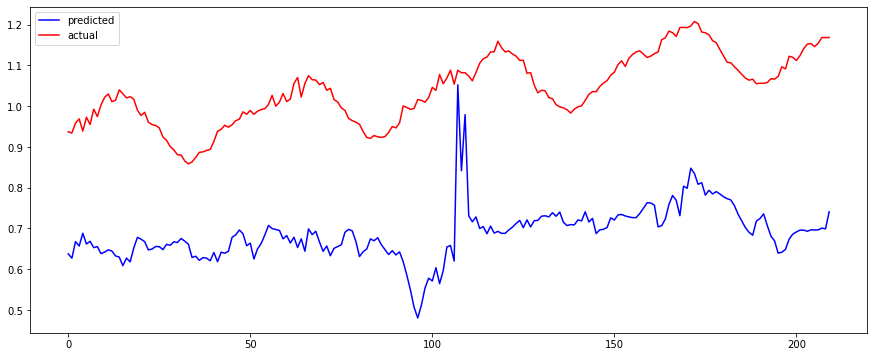

In [88]:
compare_plot(y_test_ng,y_ng_test) 

In [89]:
mse_test = mean_squared_error(y_ng_test, y_test_ng)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_ng_test, y_test_ng,squared=False)
print("Test Data RMSE = ", rmse_test)

Test Data MSE =  0.1289734737571167
Test Data RMSE =  0.35912877043912356


## Add both Nautural Gas and seasonality

In [90]:
co2_both = co2.drop(['crude_oil','NG_S'],axis=1)
co2_both['oil_futures'] = co2_both['oil_futures'].diff()
co2_both = co2_both.dropna()
co2_both

,co2_ppm,oil_futures,NG_F,spring,summer,fall,winter
Date,,,,,,,
9/11/00,367.33,2.229999,5.205,0,0,1,0
9/18/00,366.86,1.780003,5.131,0,0,1,0
9/25/00,366.86,-5.310001,5.200,0,0,1,0
10/2/00,366.78,0.580002,5.000,0,0,1,0
10/9/00,366.88,-0.270003,5.535,0,0,1,0
...,...,...,...,...,...,...,...
1/18/21,415.42,0.045001,2.446,0,0,0,1
1/25/21,416.01,-0.215000,2.564,0,0,0,1
1/25/21,416.01,8.930441,2.564,0,0,0,1


In [91]:
both_train, both_test = train_test_split_func(co2_both)
both_train=scaler.fit_transform(both_train)
both_test=scaler.transform(both_test)
X_both_train, y_both_train = window(both_train, 3)
X_both_test, y_both_test = window(both_test, 3)
print("X train shape:",X_both_train.shape, " test shape:",X_both_test.shape)
print("y train shape:",y_both_train.shape, " test shape:",y_both_test.shape)

X train shape: (849, 3, 6)  test shape: (210, 3, 6)
y train shape: (849,)  test shape: (210,)


In [92]:
# Train the base model
model0 = ModelOne(X_both_train)
model0.compile(optimizer="adam", loss="mean_squared_error")  

model0.fit(X_both_train, y_both_train, epochs=15, batch_size = 10, shuffle=True)
model0.evaluate(X_both_test, y_both_test)

# PREDICTION
y_train_both = model0.predict(X_both_train)
y_test_both = model0.predict(X_both_test)

Train on 849 samples
Epoch 1/15
849/849 [==============================] - 6s 7ms/sample - loss: 0.0832
Epoch 2/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0559
Epoch 3/15
849/849 [==============================] - 2s 2ms/sample - loss: 0.0499
Epoch 4/15
849/849 [==============================] - 2s 2ms/sample - loss: 0.0480
Epoch 5/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0451
Epoch 6/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0461
Epoch 7/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0472
Epoch 8/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0470
Epoch 9/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0454
Epoch 10/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0452
Epoch 11/15
849/849 [==============================] - 1s 2ms/sample - loss: 0.0458
Epoch 12/15
849/849 [==============================] - 1s 2ms/sa

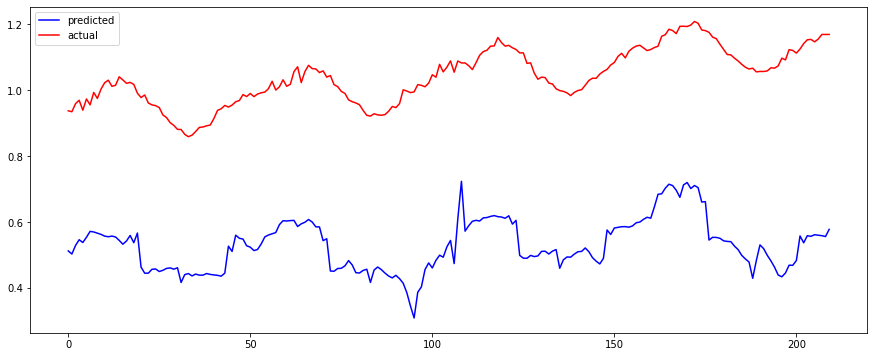

In [93]:
compare_plot(y_test_both,y_both_test) 

In [94]:
mse_test = mean_squared_error(y_both_test, y_test_both)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_both_test, y_test_both,squared=False)
print("Test Data RMSE = ", rmse_test)

Test Data MSE =  0.2651233983177248
Test Data RMSE =  0.5149013481412966


## NG Only

In [101]:
ng = co2[['co2_ppm','NG_F']]
ng = ng.dropna()
ng

,co2_ppm,NG_F
Date,,
9/4/00,367.32,4.880
9/11/00,367.33,5.205
9/18/00,366.86,5.131
9/25/00,366.86,5.200
10/2/00,366.78,5.000
...,...,...
1/18/21,415.42,2.446
1/25/21,416.01,2.564
1/25/21,416.01,2.564


In [102]:
ng_train, ng_test = train_test_split_func(ng)
ng_train=scaler.fit_transform(ng_train)
ng_test=scaler.transform(ng_test)
X_ng_train, y_ng_train = window(ng_train, 5)
X_ng_test, y_ng_test = window(ng_test, 5)
print("X train shape:",X_ng_train.shape, " test shape:",X_ng_test.shape)
print("y train shape:",y_ng_train.shape, " test shape:",y_ng_test.shape)

X train shape: (848, 5, 1)  test shape: (208, 5, 1)
y train shape: (848,)  test shape: (208,)


In [103]:
# Train the base model
model0 = ModelOne(X_ng_train)
model0.compile(optimizer="adam", loss="mean_squared_error")  

model0.fit(X_ng_train, y_ng_train, epochs=15, batch_size = 10, shuffle=True)
model0.evaluate(X_ng_test, y_ng_test)

# PREDICTION
y_train_ng = model0.predict(X_ng_train)
y_test_ng = model0.predict(X_ng_test)

Train on 848 samples
Epoch 1/15
848/848 [==============================] - 7s 8ms/sample - loss: 0.1076
Epoch 2/15
848/848 [==============================] - 2s 2ms/sample - loss: 0.0509
Epoch 3/15
848/848 [==============================] - 2s 2ms/sample - loss: 0.0520
Epoch 4/15
848/848 [==============================] - 2s 2ms/sample - loss: 0.0492
Epoch 5/15
848/848 [==============================] - 2s 2ms/sample - loss: 0.0483
Epoch 6/15
848/848 [==============================] - 2s 2ms/sample - loss: 0.0495
Epoch 7/15
848/848 [==============================] - 2s 2ms/sample - loss: 0.0485
Epoch 8/15
848/848 [==============================] - 2s 2ms/sample - loss: 0.0483
Epoch 9/15
848/848 [==============================] - 2s 2ms/sample - loss: 0.0479
Epoch 10/15
848/848 [==============================] - 2s 2ms/sample - loss: 0.0482
Epoch 11/15
848/848 [==============================] - 2s 2ms/sample - loss: 0.0493
Epoch 12/15
848/848 [==============================] - 2s 2ms/sa

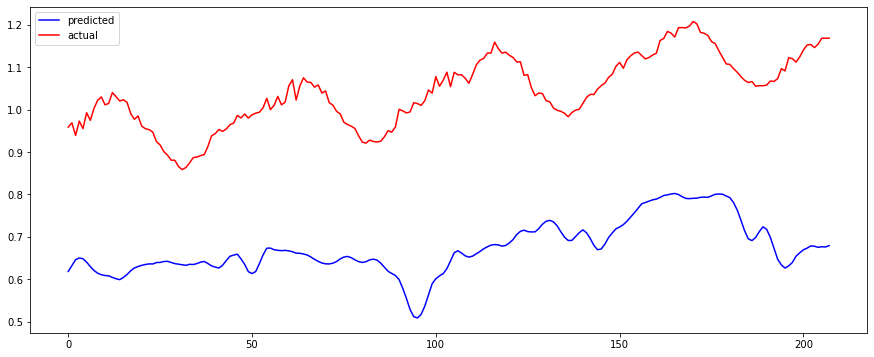

In [104]:
compare_plot(y_test_ng,y_ng_test) 

In [105]:
mse_test = mean_squared_error(y_ng_test, y_test_ng)
print("Test Data MSE = ", mse_test)
rmse_test = mean_squared_error(y_ng_test, y_test_ng,squared=False)
print("Test Data RMSE = ", rmse_test)

Test Data MSE =  0.1396561510846956
Test Data RMSE =  0.37370596875711737
